In [138]:
import json
import numpy as np
import random

from lttb import LTTB

from env import Unlock

from tqdm import tqdm, trange
from itertools import product as Prod

import matplotlib
import matplotlib.pyplot as plt

In [139]:
# ============= TEST FUNCTION =================
def test (lttb, env, testset, par):
    rt, rb = r = (par['rt'], par['rb'])
    size = np.shape(testset)[-1]

    hist = {'agent'  : np.zeros ((size, par['T'], 2)),
            'action' : np.zeros ((size, par['T'], par['O'])),
            'theta'  : np.zeros (size),
            'R'      : np.zeros (size)}

    tars = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in testset])
    btns =  [(0., rb)] * len (testset)

    for i, (targ, btn) in enumerate (zip (tars, btns)):
        env.reset (init = init, targ = targ, btn = btn)
        lttb.initialize(par)
        R = 0

        state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

        for t in range (par['T']):
            action, _ = lttb.step (apicalFactor =0)
            state, r, done, agen = env.step (action)

            R = max (R, r)

            hist['action'][i, t] = action
            hist['agent'][i, t]  = agen

            if done: break

        hist['action'][i, t:] = np.nan
        hist['agent'][i, t:]  = agen
        hist['theta'][i]      = testset[i]
        hist['R'][i]          = R

    return hist

In [140]:
"""
sigma_in = 5
!!! -> fare test su tutti angoli 0-360, calcolare R come distanza minima tra bottone e array posizioni, poi fare plot e
   sovrapporre angoli di training
-> sparsificare l'input e/o il contesto
-> provare reaching studiando di piu' o diminuendo il numero di esempi (n_context=20 usato in due punti diversi del codice)
-> l'esperto raggiunge il bottone sempre a t=60, ovunque il bottone sia; questo implica velocita' diverse;
   possiamo o settare la velocita' ad una costante, quindi cambiando il tempo di reach del bottone, o semplicemente estrarre
   i bottoni su una circonferenza di raggio fissato
"""

"\nsigma_in = 5\n!!! -> fare test su tutti angoli 0-360, calcolare R come distanza minima tra bottone e array posizioni, poi fare plot e\n   sovrapporre angoli di training\n-> sparsificare l'input e/o il contesto\n-> provare reaching studiando di piu' o diminuendo il numero di esempi (n_context=20 usato in due punti diversi del codice)\n-> l'esperto raggiunge il bottone sempre a t=60, ovunque il bottone sia; questo implica velocita' diverse;\n   possiamo o settare la velocita' ad una costante, quindi cambiando il tempo di reach del bottone, o semplicemente estrarre\n   i bottoni su una circonferenza di raggio fissato\n"

In [141]:
# Loading configuration file
path = 'config.json'
config = 'BUTTON_FOOD'

n_examples = 10

with open (path, 'r') as f:
    par = json.load (f)[config]

par['hint'] = par['hint'] == 'True'
par['clump'] = par['clump'] == 'True'
par['validate'] = par['validate'] == 'True'
par['verbose'] = par['verbose'] == 'True'

# ==== Environment Initialization ======
init = np.array ((0., 0.))
targ = np.array ((0., 1.))
btn = np.array ((0., 0.))

env = Unlock (init = init, targ = targ, btn = btn, unit = (par['dt'], par['dx']), res = 20)

rt, rb = par['rt'], par['rb']

trainset = np.array (par['trainset'])
validset = np.array (par['validset'])
testset  = np.linspace (*par['testset'])

train_theta = trainset * np.pi / 180.
valid_theta = validset * np.pi / 180.
test_theta  = testset * np.pi / 180.

#train_targs = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in train_theta])

train_targs = (np.random.rand(n_examples,2)-.5)*2#np.array ([( np.random.rand(1) , np.random.rand(1) ) for t in train_theta])

#train_thetas = [random.random()*2*np.pi for i in range(n_examples)]
train_thetas = np.linspace(0,2*np.pi,n_examples,endpoint=False)

train_bttns = np.array ([(1 * np.cos (t), 1 * np.sin (t)) for t in train_thetas])
#train_bttns = (np.random.rand(20,2)-.5)*2#np.array ([(0, rb) for t in train_theta])

#valid_targs = np.array ([(rt * np.cos (t), rt * np.sin (t)) for t in valid_theta])


In [142]:
np.shape(train_targs)

(10, 2)

In [143]:

#valid_bttns = np.array ([(rb * np.cos (t), rb * np.sin (t)) for t in valid_theta])

tb = 60
tf = 60

# Here we ask the env for the expert behaviour
epar = {'offT' : (1, 1), 'steps' : (tb-1, tf-1), 'T' : (tb, tf)}
train_exp = [env.build_expert (targ, init, btn, **epar) for targ, btn in zip (train_targs, train_bttns)]
#valid_exp = [env.build_expert (targ, init, btn, **epar) for targ, btn in zip (valid_targs, valid_bttns)]



In [204]:
N, I, O, T = 500, 80, 2, tb+tf
shape = (N, I, O, T)

dt = .001
tau_m = 20. * dt
tau_s = 2. * dt
tau_ro = 10. * dt
tau_star = 20. * dt
tau_W = 200 * dt


beta = np.exp(-dt/tau_s)
beta_ro = np.exp(-dt/tau_ro)
beta_targ = np.exp(-dt/tau_star)
beta_W = np.exp(-dt/tau_W)

sigma_context = 50.
sigma_targ = 5. #10**1.5
sigma_in = 20. #12.

dv = 1 / 500.
alpha = .005
alpha_rout = .01
Vo = - 4
h = - 1
s_inh = 20

sigma_Jrec = 0.
sigma_wrec = 0.
sigma_Jout = 0.1

Ne = 400
Ni = 100

N = Ne+Ni

n_contexts = n_examples

# Here we build the dictionary of the simulation parameters
par = {'dt' : dt, 'tau_m' : tau_m, 'tau_s' : tau_s, 'tau_ro' : tau_ro, 'tau_star' : tau_star,'tau_W' : tau_W,
       'dv' : dv, 'Vo' : Vo, 'h' : h, 's_inh' : s_inh,
       'N' : N, 'Ni' : Ni, 'Ne' : Ne, 'T' : T, 'I' : I, 'O' : O, 'shape' : shape, 
       'sigma_Jrec' : sigma_Jrec,'sigma_wrec' : sigma_wrec, 'sigma_Jout' : sigma_Jout,  'n_contexts' : n_contexts,
       'alpha' : alpha, 'alpha_rout' : alpha_rout,
       'sigma_in' : sigma_in, 'sigma_targ' : sigma_targ, 'sigma_context' : sigma_context, 'h' : h}

par_low = par
par_high = par

par_high['sigma_Jrec'] = 0
par_low['sigma_targ'] = 0
par_high['sigma_targ'] = 30

TIME = 1.

T = int(np.floor(TIME/dt))

nStepOutTraining = 1000

t_shut = 2

JMAX = 100.
nu_targ = 0.005

# Here we init our (recurrent) agent
lttb_low = LTTB (par_low)
lttb_high = LTTB (par_high)

In [205]:
# define clock and target

lttb_low.y_targ_collection = []
lttb_low.I_clock_collection = []

lttb_high.y_targ_collection = []
lttb_high.I_clock_collection = []

for k in range(n_examples):
    
    lttb_low.y_targ_collection.append( train_exp[k][1] )
    lttb_low.I_clock_collection.append( train_exp[k][0] )
    
    lttb_high.y_targ_collection.append( np.array([[1. if t<tb else 0. for t in range(tb+tf)],[0. if t<tb else 1. for t in range(tb+tf)]]) )
    lttb_high.I_clock_collection.append( train_exp[k][0] ) # same as low network
    
    
    #lttb.y_targ_collection.append( train_exp[k][1].T[0:tb].T )
    #lttb.I_clock_collection.append( train_exp[k][0].T[0:tb].T )

In [206]:
np.shape(lttb_high.y_targ_collection)

(10, 2, 120)

In [207]:
"""
for k in range(n_contexts):

    plt.figure()
    plt.subplot(311)
    plt.plot(np.array(lttb.y_targ_collection[k]).T)
    plt.ylabel('$y_{targ}$')
    plt.subplot(212)
    plt.plot(np.array(lttb.I_clock_collection[k]).T)
    plt.xlabel('time(s)')
    plt.ylabel('clock')
"""

"\nfor k in range(n_contexts):\n\n    plt.figure()\n    plt.subplot(311)\n    plt.plot(np.array(lttb.y_targ_collection[k]).T)\n    plt.ylabel('$y_{targ}$')\n    plt.subplot(212)\n    plt.plot(np.array(lttb.I_clock_collection[k]).T)\n    plt.xlabel('time(s)')\n    plt.ylabel('clock')\n"

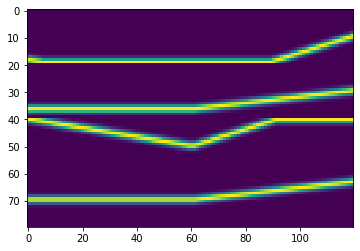

In [208]:
plt.imshow(np.array(lttb_low.I_clock_collection[5]))


In [209]:
## Training Rec
par['T'] = tb+tf
lttb_low.T = tb+tf
lttb_high.T = tb+tf

gamma = 10.
def f(x,gamma):
    return np.exp(x*gamma)/(np.exp(x*gamma)+1)
#f1 = @(x)(gamma*exp(gamma*x))./(exp(gamma*x)+1)-(gamma*exp(2*gamma*x))./(exp(gamma*x)+1).^2;

apicalFactorTrain = 1
apicalFactorTest = 0

nIterRec = 50

eta = 100.
eta_out = 0.03
etaW = .0

##############################

SR_low_list = []
SR_high_list = []

for cont_index in range(n_examples):
    
    lttb_low.initialize(par_low)
    lttb_low.y_targ = lttb_low.y_targ_collection[cont_index]
    lttb_low.I_clock = lttb_low.I_clock_collection[cont_index]
    
    lttb_high.initialize(par_high)
    lttb_high.y_targ = lttb_high.y_targ_collection[cont_index]
    lttb_high.I_clock = lttb_high.I_clock_collection[cont_index]
    
    for t in range(lttb_low.T-2):
        
        lttb_low.cont = lttb_high.y_targ.T[t]
        lttb_high.cont = np.array([0,0])
        
        lttb_low.step(apicalFactor = apicalFactorTrain)
        lttb_high.step(apicalFactor = apicalFactorTrain)
        
        SR_low = lttb_low.B_filt[:,t+1] # lttb.S_filtRO[:,t+1]
        SR_high = lttb_high.B_filt[:,t+1] # lttb.S_filtRO[:,t+1]
        
    SR_low_list.append(lttb_low.B_filt)
    SR_high_list.append(lttb_high.B_filt)

print('...done.')

...done.


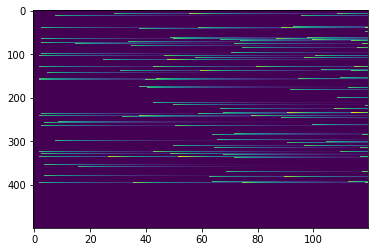

In [210]:
plt.imshow(lttb_high.B_filt[:,:], aspect='auto')
plt.show()

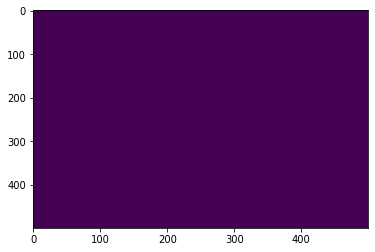

In [211]:
plt.imshow(lttb_high.J, aspect='auto')
plt.show()

In [212]:
#####################################

test_every = 2

ERRORS_low = np.zeros((int(nIterRec/test_every),n_examples))
ERRORS_high = np.zeros((int(nIterRec/test_every),n_examples))

for iteration in range(nIterRec):

    print(iteration)
    
    ###### Online-Training

    #initialize simulation
    
    for cont_index in range(n_examples):
        
        lttb_low.y_targ = lttb_low.y_targ_collection[cont_index]
        lttb_high.y_targ = lttb_high.y_targ_collection[cont_index]
        
        #ON-LINE
        
        lttb_low.initialize(par_low)
        lttb_high.initialize(par_high)
        
        lttb_low.I_clock = lttb_low.I_clock_collection[cont_index]
        lttb_high.I_clock = lttb_high.I_clock_collection[cont_index]
        
        #run simulation
        dH = 0
        
        for t in range(lttb_low.T-2):
            
            lttb_low.cont = lttb_high.y_targ.T[t]
            lttb_high.cont = np.array([0,0])
                
            lttb_low.step(apicalFactor = apicalFactorTest)
            lttb_high.step(apicalFactor = apicalFactorTest)
            
            dH = dH*(1-dt/tau_m) + dt/tau_m*lttb_high.S_filt[:,t]
            DJ = np.outer(( lttb_high.S_apic_dist[:,t+1] - f(lttb_high.VapicRec[:,t],gamma) )*(1-lttb_high.S_apic_dist[:,t]) ,dH)
            lttb_high.J =  lttb_high.J + eta*DJ
            
            SR_low = lttb_low.B_filt[:,t+1] # lttb.S_filtRO[:,t+1]
            Y_low = lttb_low.Jout@SR_low
            DJRO = np.outer(lttb_low.y_targ[:,t+1] - Y_low,SR_low.T)
            lttb_low.Jout =  lttb_low.Jout + eta_out*DJRO
            
            SR_high = lttb_high.B_filt[:,t+1] # lttb.S_filtRO[:,t+1]
            Y_high = lttb_high.Jout@SR_high
            DJRO = np.outer(lttb_high.y_targ[:,t+1] - Y_high,SR_high.T)
            lttb_high.Jout =  lttb_high.Jout + eta_out*DJRO
            
        """
        #OFF-LINE
        
        SR = SR_list[cont_index]
        Y = lttb.Jout@SR
        DJRO = (lttb.y_targ[:,1:-1] - Y[:,0:-2]) @ ( SR.T[0:-2])
        lttb.Jout =  lttb.Jout + eta_out*DJRO
        """
       
        
    ###### Test
    
    if (iteration+1)%test_every==0:
        
        for cont_index in range(n_examples):
            
            lttb_low.initialize(par_low)
            lttb_high.initialize(par_high)
        
            lttb_low.I_clock = lttb_low.I_clock_collection[cont_index]
            lttb_high.I_clock = lttb_high.I_clock_collection[cont_index]
            
            lttb_low.y_targ = lttb_low.y_targ_collection[cont_index]
            lttb_high.y_targ = lttb_high.y_targ_collection[cont_index]

            #run simulation

            for t in range(lttb_low.T-2):
                
                lttb_low.cont = lttb_high.y_targ.T[t]
                lttb_high.cont = np.array([0,0])
                
                lttb_low.step(apicalFactor = apicalFactorTest)
                lttb_high.step(apicalFactor = apicalFactorTest)

            SR_low = lttb_low.B_filt[:,1:-2] # lttb.S_filtRO[:,1:-2]
            Y_low = lttb_low.Jout@SR_low
            mse_ro_train_low = np.std(lttb_low.y_targ[:,1:-2] - Y_low)**2
            
            SR_high = lttb_high.B_filt[:,1:-2] # lttb.S_filtRO[:,1:-2]
            Y_high = lttb_high.Jout@SR_high
            mse_ro_train_high = np.std(lttb_high.y_targ[:,1:-2] - Y_high)**2
            
            ERRORS_low[int(iteration/test_every),cont_index] = mse_ro_train_low
            ERRORS_high[int(iteration/test_every),cont_index] = mse_ro_train_high

print('...done.')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
...done.


In [199]:
np.shape(DJ)

(500, 500)

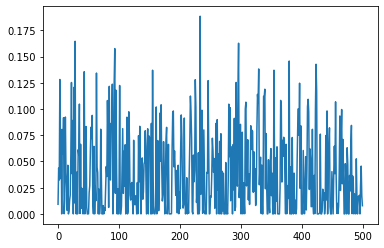

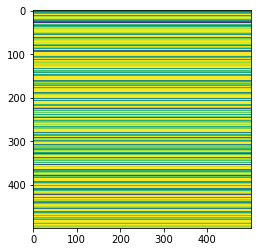

In [200]:
plt.plot(dH)
plt.show()

plt.imshow(DJ.T)
plt.show()

TypeError: Invalid shape (500,) for image data

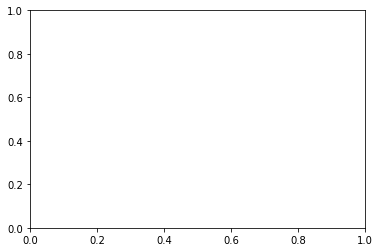

In [195]:
plt.imshow(dH, aspect='auto')
plt.show()

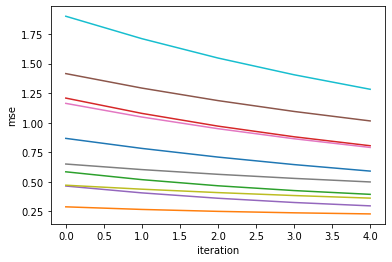

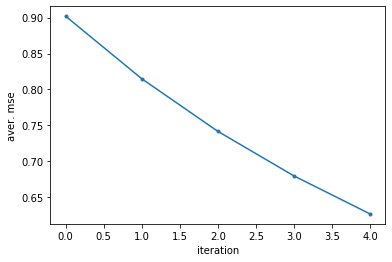

In [157]:
plt.figure()
plt.plot(ERRORS_low)
plt.xlabel("iteration")
plt.ylabel("mse")
plt.show()

plt.plot([np.mean(ERRORS_low[_,:]) for _ in range(len(ERRORS_low))], marker='.')
plt.xlabel("iteration")
plt.ylabel("aver. mse")
plt.show()

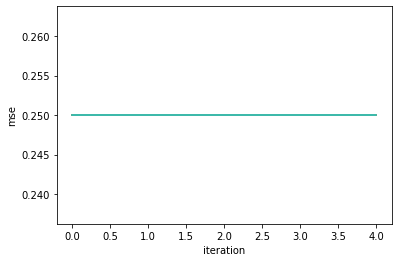

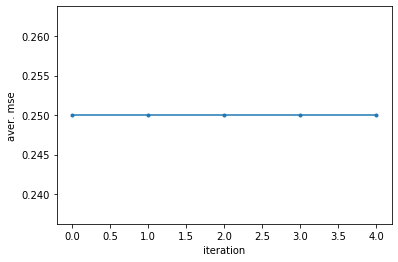

In [158]:
plt.figure()
plt.plot(ERRORS_high)
plt.xlabel("iteration")
plt.ylabel("mse")
plt.show()

plt.plot([np.mean(ERRORS_high[_,:]) for _ in range(len(ERRORS_high))], marker='.')
plt.xlabel("iteration")
plt.ylabel("aver. mse")
plt.show()

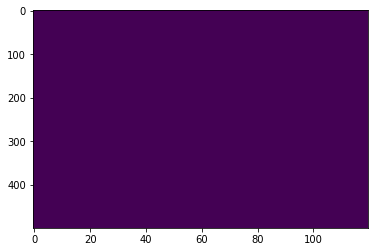

In [160]:
plt.imshow(lttb_high.B_filt, aspect='auto')
#@lttb_high.B_filt[:,1:-2])[0])
plt.show()

0.4065085273827689 0.25


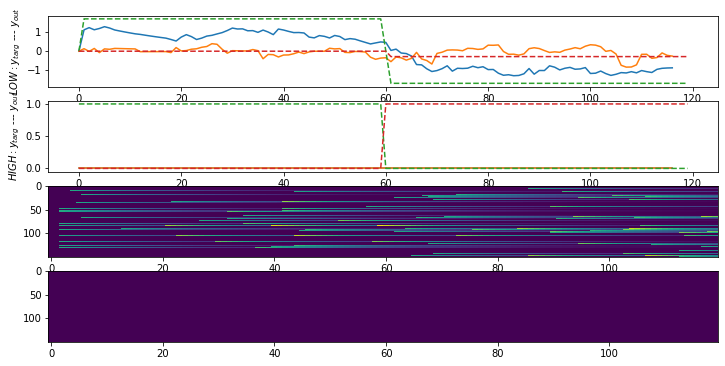

0.20470768835110523 0.25


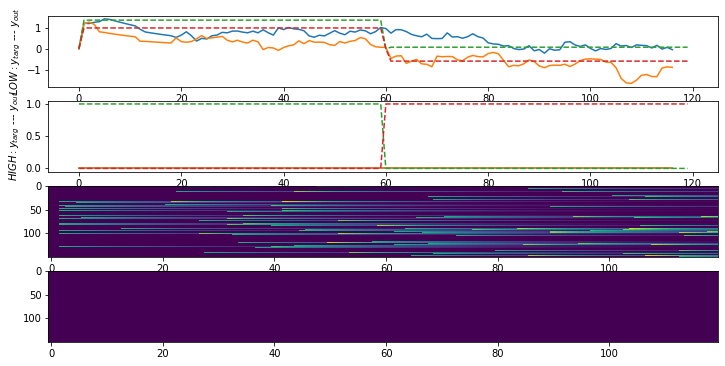

0.30968112097478245 0.25


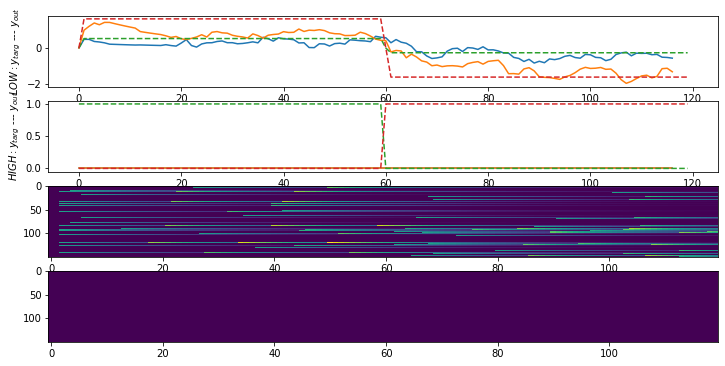

0.5667904418358428 0.25


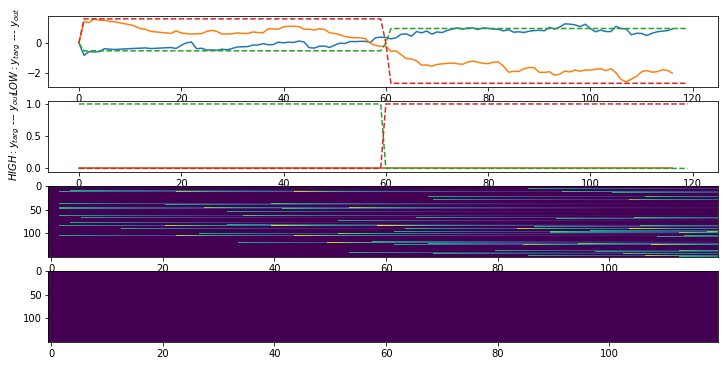

0.22028275785747523 0.25


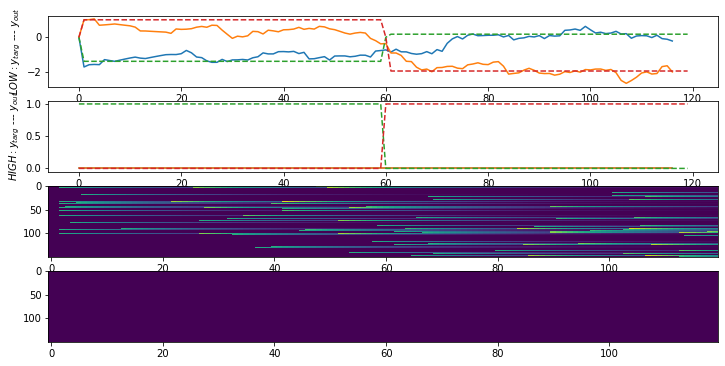

0.7372217179721007 0.25


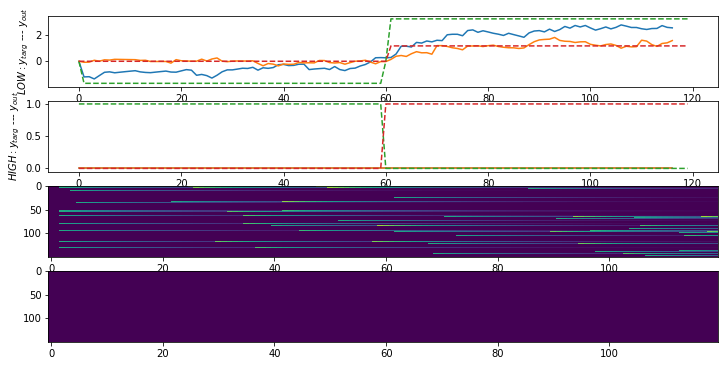

0.5438204730494579 0.25


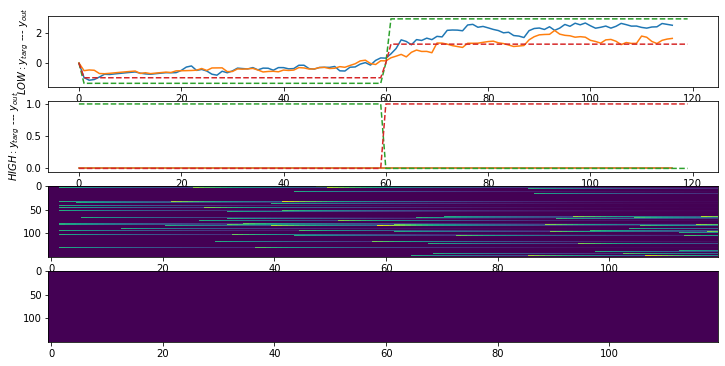

0.3912600608185212 0.25


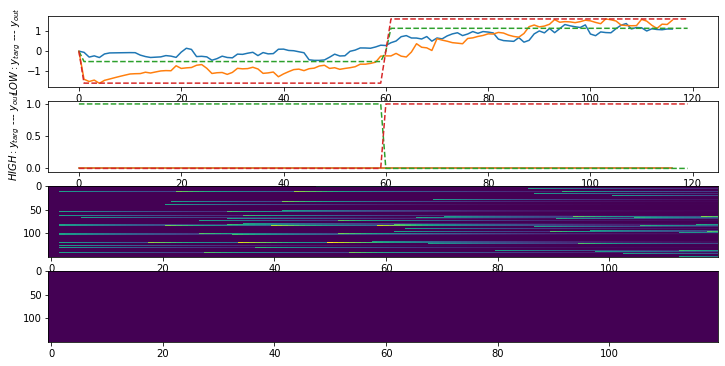

0.2855286462297243 0.25


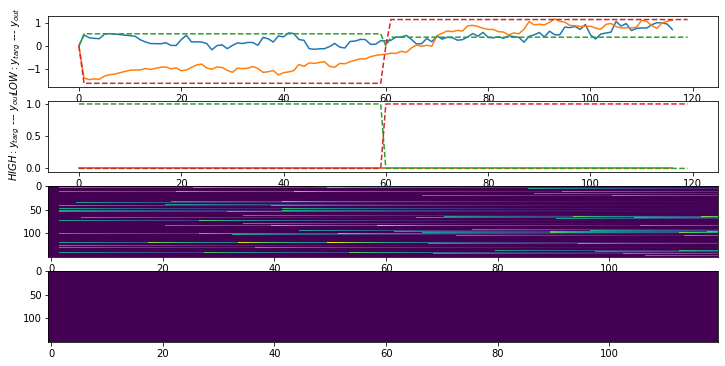

0.8684234356355764 0.25


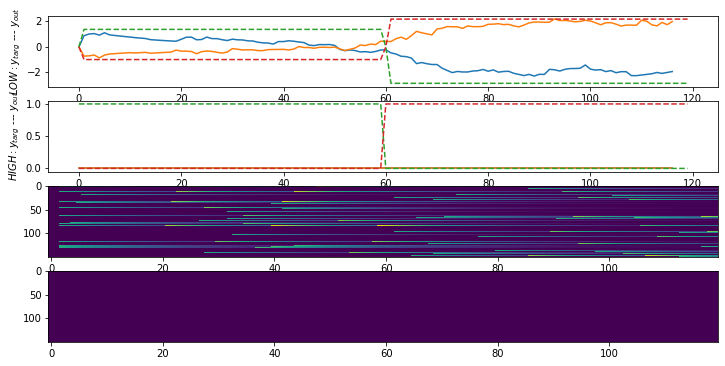

In [165]:
for cont_index in range(n_examples):
    
    lttb_low.initialize(par_low)
    lttb_high.initialize(par_high)
    
    lttb_low.I_clock = lttb_low.I_clock_collection[cont_index]
    lttb_high.I_clock = lttb_high.I_clock_collection[cont_index]
    
    lttb_low.y_targ = lttb_low.y_targ_collection[cont_index]
    lttb_high.y_targ = lttb_high.y_targ_collection[cont_index]
    
    #run simulation
    
    for t in range(lttb_low.T-2):
        
        lttb_low.cont = lttb_high.y_targ.T[t]
        lttb_high.cont = np.array([0,0])
        
        lttb_low.step(apicalFactor = apicalFactorTest)
        lttb_high.step(apicalFactor = apicalFactorTest)
    
    SR_low = lttb_low.B_filt[:,1:-2] # lttb.S_filtRO[:,1:-2]
    Y_low = lttb_low.Jout@SR_low
    mse_ro_train_low = np.std(lttb_low.y_targ[:,1:-2] - Y_low)**2
    
    SR_high = lttb_high.B_filt[:,1:-2] # lttb.S_filtRO[:,1:-2]
    Y_high = lttb_high.Jout@SR_high
    mse_ro_train_high = np.std(lttb_high.y_targ[:,1:-2] - Y_high)**2
    
    print(mse_ro_train_low,mse_ro_train_high)
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(411)
    plt.plot(Y_low.T)
    plt.plot(lttb_low.y_targ.T,'--')
    #plt.plot(np.array(context),'--')
    plt.xlabel('time(s)')
    plt.ylabel('$LOW: y_{targ}$ --- $y_{out}$')
    
    plt.subplot(412)
    plt.plot(Y_high.T)
    plt.plot(lttb_high.y_targ.T,'--')
    #plt.plot(np.array(context),'--')
    plt.xlabel('time(s)')
    plt.ylabel('$HIGH: y_{targ}$ --- $y_{out}$')
    
    plt.subplot(413)
    plt.imshow(lttb_low.B_filt[0:150,:],aspect='auto')
    #plt.plot(lttb.B_filt_rec.T)
    
    plt.subplot(414)
    plt.imshow(lttb_high.B_filt[0:150,:],aspect='auto')
    
    #plt.subplot(313)
    #plt.imshow(lttb.S_wind[0:20,:],aspect='auto')
    
    plt.show()

In [438]:
def make_test(btn_theta, show_plot=True):
    
    TIME_TEST = 1500

    par['T'] = TIME_TEST
    lttb.T = TIME_TEST
    lttb.initialize(par)

    lttb.y_targ = np.zeros((lttb.O,lttb.T))

    #targ_test = train_targs[cont_index]
    #btn_test = train_bttns[cont_index]

    #theta = 30
    #theta = theta/180*np.pi
    targ_test = (np.random.rand(2)-.5)
    #btn_test = (np.random.rand(2)-.5)
    
    btn_radius = 0.1
    btn_dist = 1.0
    btn_test = (btn_dist * np.cos (btn_theta), btn_dist * np.sin (btn_theta))
    btn = btn_test
    
    trajectory = np.zeros((2,TIME_TEST-1))
    trajectory[:,0] = init

    env.reset (init = init, targ = targ_test, btn = btn_test)

    agen = init

    R = 0

    ACTIONS = []
    POSITION = []#np.zeros((2,TIME_TEST-2))

    state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

    #lttb.I_clock[:,0] *= 0

    #state, r, done, agen = env.step ([0,0])
    lttb.I_clock[:,0] = state#lttb.I_clock_collection[cont_index][:,0]

    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    closed_loop = 1

    context = []

    btn_on=0

    for t in range (TIME_TEST-2):

        if closed_loop:
            lttb.I_clock[:,lttb.t+1] = state
            if np.sqrt( np.sum((agen - btn_test)**2) ) < btn_radius:

                btn_on=1

                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        else:
            lttb.I_clock[:,lttb.t+1] = lttb.I_clock_collection[cont_index][:,lttb.t+1]
            if t == tb:
                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        context.append(lttb.cont)

        lttb.step (apicalFactor = 0)
        action = lttb.Jout@lttb.B_filt[:,t]
        ACTIONS.append(action)

        state, r, done, agen = env.step (action)

        #POSITION[:,t] = agen
        POSITION.append( list(agen) )

        R = max (R, r)

        if np.sqrt( np.sum((agen - targ_test)**2) )  < 0.1 and btn_on==1:
            done = 1

        if done: break


    min_btn_dist = min([np.sqrt( np.sum((np.array(POSITION)[_,:] - btn_test)**2) ) for _ in range(len(POSITION))])
    print('btn_theta = %.3f' % btn_theta)
    print('R = %.3f' % R)
    print('min_btn_dist = %.3f' % min_btn_dist)
    
    if show_plot:
        plt.figure()
        #plt.plot(trajectory[0],trajectory[1],'o')
        plt.scatter(0,0,marker='X',color='black')
        plt.plot(np.array(POSITION)[:,0],np.array(POSITION)[:,1],'-')
        plt.plot(targ_test[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),targ_test[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'k-')
        plt.plot(btn_test[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),btn_test[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'r-')
        plt.scatter([1*np.cos(t) for t in np.linspace(0,2*np.pi,100)],[1*np.sin(t) for t in np.linspace(0,2*np.pi,100)], color='green', marker='.')
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        plt.show()
    
    return R,min_btn_dist

NameError: name 'POSITION' is not defined

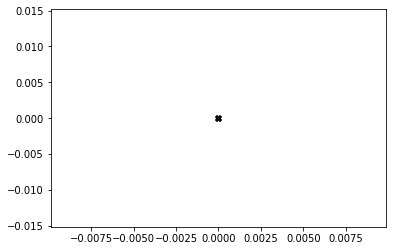

In [439]:
plt.figure()
#plt.plot(trajectory[0],trajectory[1],'o')
plt.scatter(0,0,marker='X',color='black')
plt.plot(np.array(POSITION)[:,0],np.array(POSITION)[:,1],'-')
plt.plot(targ_test[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),targ_test[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'k-')
plt.plot(btn_test[0]+0.1*np.cos(np.linspace(0,2*np.pi,100)),btn_test[1]+0.1*np.sin(np.linspace(0,2*np.pi,100)),'r-')
plt.scatter([1*np.cos(t) for t in np.linspace(0,2*np.pi,100)],[1*np.sin(t) for t in np.linspace(0,2*np.pi,100)], color='green', marker='.')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

In [440]:
#btn_theta = random.random()*2*np.pi

Rs = []
dists = []

for th in np.linspace(0,1,30,endpoint=False):
    btn_theta = th*2*np.pi
    R,min_btn_dist = make_test(btn_theta,show_plot=False)
    Rs.append(R)
    dists.append(min_btn_dist)

btn_theta = 0.000
R = 0.768
min_btn_dist = 0.069
btn_theta = 0.209
R = 1.290
min_btn_dist = 0.088
btn_theta = 0.419
R = 1.068
min_btn_dist = 0.039
btn_theta = 0.628
R = 1.452
min_btn_dist = 0.019
btn_theta = 0.838
R = 0.616
min_btn_dist = 0.076
btn_theta = 1.047
R = 1.001
min_btn_dist = 0.052
btn_theta = 1.257
R = 1.355
min_btn_dist = 0.015
btn_theta = 1.466
R = 0.740
min_btn_dist = 0.038
btn_theta = 1.676
R = 0.761
min_btn_dist = 0.025
btn_theta = 1.885
R = 1.010
min_btn_dist = 0.096
btn_theta = 2.094
R = 0.997
min_btn_dist = 0.059
btn_theta = 2.304
R = 0.000
min_btn_dist = 0.140
btn_theta = 2.513
R = 0.872
min_btn_dist = 0.007
btn_theta = 2.723
R = 1.604
min_btn_dist = 0.043
btn_theta = 2.932
R = 10.148
min_btn_dist = 0.097
btn_theta = 3.142
R = 10.092
min_btn_dist = 0.042
btn_theta = 3.351
R = 10.627
min_btn_dist = 0.067
btn_theta = 3.560
R = 3.186
min_btn_dist = 0.050
btn_theta = 3.770
R = 10.707
min_btn_dist = 0.087
btn_theta = 3.979
R = 3.300
min_btn_dist = 0.058
btn_theta = 4.18

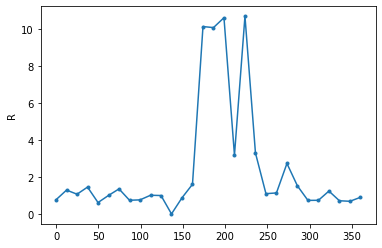

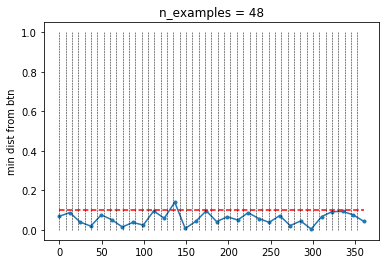

In [441]:
plt.plot(np.linspace(0,1,30)*360,Rs,marker='.')
plt.ylabel('R')
plt.show()

plt.title('n_examples = %d' % n_examples)
plt.plot(np.linspace(0,1,30)*360,dists,marker='.')
plt.plot([0,360],[0.1,0.1],ls='--',color='red')
for th in train_thetas:
    plt.plot([th/2/np.pi*360,th/2/np.pi*360],[0,1],ls='--',color='black',lw=0.5)
plt.ylabel('min dist from btn')
plt.show()

In [290]:
train_thetas

[2.52299293616753,
 0.969591500857559,
 1.140708900302102,
 3.0029161643653492,
 0.2310405821856491,
 0.6681815597950457,
 1.6523718323579166,
 0.6707626586301276,
 5.261259910639258,
 4.575919047460333,
 3.91796055546683,
 6.213717040553316,
 2.850080279385435,
 6.160270525171928,
 5.325837119068753,
 5.354466268829198,
 1.4029414667225832,
 5.5067320269454,
 3.988463532280372,
 5.016327747526899]

In [27]:
np.array(POSITION)[0,:]
print( np.sqrt( np.sum((np.array(POSITION)[50,:] - btn_test)**2) ) )

NameError: name 'POSITION' is not defined

In [ ]:
plt.figure()
plt.subplot(211)
plt.plot(POSITION[0,:])
plt.plot(POSITION[1,:])
plt.subplot(212)

plt.plot(context)

In [74]:
TIME_TEST = 1500

par['T'] = TIME_TEST
lttb.T = TIME_TEST

REWARDS = []

for rep in range(20):

    lttb.initialize(par)

    lttb.y_targ = np.zeros((lttb.O,lttb.T))

    targ_test = (np.random.rand(2)-.5)
    btn_test = (np.random.rand(2)-.5)

    trajectory = np.zeros((2,TIME_TEST-1))
    trajectory[:,0] = init

    env.reset (init = init, targ = targ_test, btn = btn_test)

    agen = init

    R = 0

    ACTIONS = []
    POSITION = np.zeros((2,TIME_TEST))

    state = np.hstack ((env.encode (targ - init), env.encode (btn - init)))

    #lttb.I_clock[:,0] *= 0

    #state, r, done, agen = env.step ([0,0])
    lttb.I_clock[:,0] = state#lttb.I_clock_collection[cont_index][:,0]

    lttb.cont = lttb.cont*0
    lttb.cont[0] = 1

    closed_loop = 1

    context = []

    for t in range (TIME_TEST-2):

        if closed_loop:
            lttb.I_clock[:,lttb.t+1] = state
            if np.sqrt( np.sum((agen - btn_test)**2) ) < 0.1:

                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        else:
            lttb.I_clock[:,lttb.t+1] = lttb.I_clock_collection[cont_index][:,lttb.t+1]
            if t == tb:
                lttb.cont = lttb.cont*0
                lttb.cont[1] = 1

        context.append(lttb.cont)

        lttb.step (apicalFactor = 0)
        action = lttb.Jout@lttb.B_filt[:,t]
        ACTIONS.append(action)

        state, r, done, agen = env.step (action)

        POSITION[:,t] = agen
        R = max (R, r)

        if np.sqrt( np.sum((agen - targ_test)**2) ) < 0.1:
            done = 1

        if done: break
            
    REWARDS.append(R)

    print('R = ' + str(R))

    


R = 0
R = 0
R = 0
R = 0
R = 4.626371807823789
R = 0
R = 10.341577828430156
R = 10.271286194102471
R = 0
R = 5.636280050593238
R = 0
R = 0
R = 0
R = 0
R = 0
R = 4.796671672409694
R = 0
R = 10.042919213210986
R = 0
R = 0


Text(0.5, 0, 'Reward')

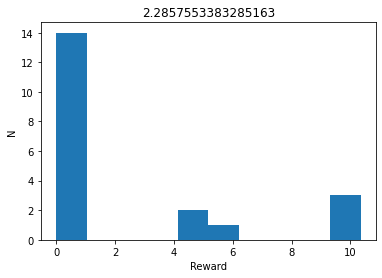

In [75]:
plt.hist(REWARDS)
plt.title(np.array(REWARDS).mean())
plt.ylabel("N")
plt.xlabel("Reward")